In [1]:
import os
import sys
import random
import warnings
import math

import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage.transform import resize

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

IMG_WIDTH = 128 # for faster computing
IMG_HEIGHT = 128 # for faster computing
IMG_CHANNELS = 3

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [3]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [4]:
image = imread("./images/DSC00758.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.05,
        minNeighbors=5,
        minSize=(30, 30)
)

print("Found {0} Faces!".format(len(faces)))

Found 27 Faces!


In [5]:
dim_x, dim_y = image.shape[0], image.shape[1]
transpose_x, transpose_y = dim_x *0.05, dim_y * 0.05

X = np.zeros((len(faces), 128, 128, 3), dtype=np.float32)
X_positions = []

index=0
for (x, y, w, h) in faces:
    transpose_x, transpose_y = w * 0.75, h * 0.75
    x_img = math.floor(x-transpose_x) if math.floor(x-transpose_x) >= 0 else 0
    y_img = math.floor(y-transpose_y) if math.floor(y-transpose_y) >= 0 else 0
    w_img = math.floor(w+2*transpose_x) if x_img + math.floor(w+2*transpose_x) <= image.shape[1] else image.shape[1] - x_img
    h_img = math.floor(h+2*transpose_y) if y_img + math.floor(w+2*transpose_y) <= image.shape[0] else image.shape[0] - y_img
    X_positions.append([x_img, y_img, w_img, h_img])
#     2d array of cropped image
    roi_color = image[y_img:h_img+y_img, x_img:w_img+x_img]
    X [index] = resize(roi_color, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    index +=1

In [6]:
model.load_weights('face-segmentation.h5')

preds_test = model.predict(X, verbose=1)
preds_test = (preds_test > 0.9).astype(np.uint8)

27/27 [==============================] - 2s 93ms/step


Text(0.5, 1.0, 'Mask')

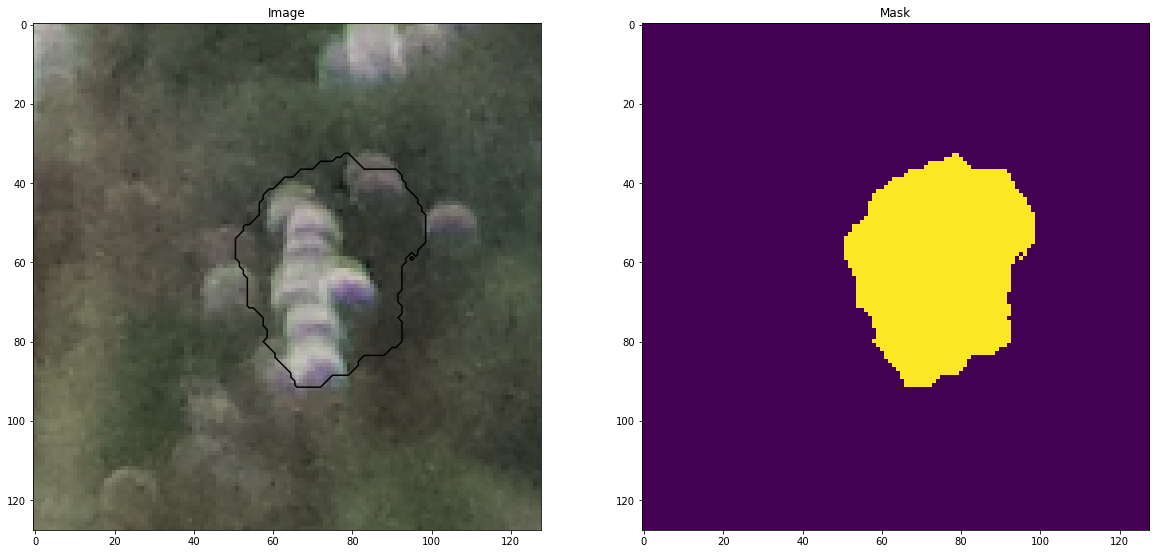

In [7]:
i=0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(X[i].astype('uint8'))
ax1.contour(preds_test[i].squeeze(), colors='k', levels=[0.5])
ax1.set_title('Image')

ax2.imshow(preds_test[i].squeeze(), vmin=0, vmax=1)
ax2.set_title('Mask')

In [8]:
upsampled_mask = np.zeros((dim_x, dim_y), dtype=np.uint8)

for i in range(len(preds_test)):
    print(i)
    coords = X_positions[i]
    section = resize(np.squeeze(preds_test[i]), 
                 (coords[3], coords[2]), mode='constant', preserve_range=True)
    print(image.shape)
    print(coords[0], coords[2])
    upsampled_mask[coords[1]:coords[3]+coords[1], coords[0]:coords[2]+coords[0]] += section.astype(np.uint8)[0:coords[3], 0:coords[2]]
    
    

0
(4000, 6000, 3)
1694 170
1
(4000, 6000, 3)
4376 167
2
(4000, 6000, 3)
3099 140
3
(4000, 6000, 3)
3537 95
4
(4000, 6000, 3)
3157 185
5
(4000, 6000, 3)
5720 280
6
(4000, 6000, 3)
3064 182
7
(4000, 6000, 3)
5477 202
8
(4000, 6000, 3)
2672 152
9
(4000, 6000, 3)
1922 90
10
(4000, 6000, 3)
2458 580
11
(4000, 6000, 3)
1918 120
12
(4000, 6000, 3)
1259 517
13
(4000, 6000, 3)
1524 170
14
(4000, 6000, 3)
3661 445
15
(4000, 6000, 3)
3621 162
16
(4000, 6000, 3)
1913 135
17
(4000, 6000, 3)
286 155
18
(4000, 6000, 3)
2312 140
19
(4000, 6000, 3)
4138 165
20
(4000, 6000, 3)
3616 517
21
(4000, 6000, 3)
4069 307
22
(4000, 6000, 3)
468 367
23
(4000, 6000, 3)
808 190
24
(4000, 6000, 3)
2255 457
25
(4000, 6000, 3)
1593 432
26
(4000, 6000, 3)
1194 182


Text(0.5, 1.0, 'Mask')

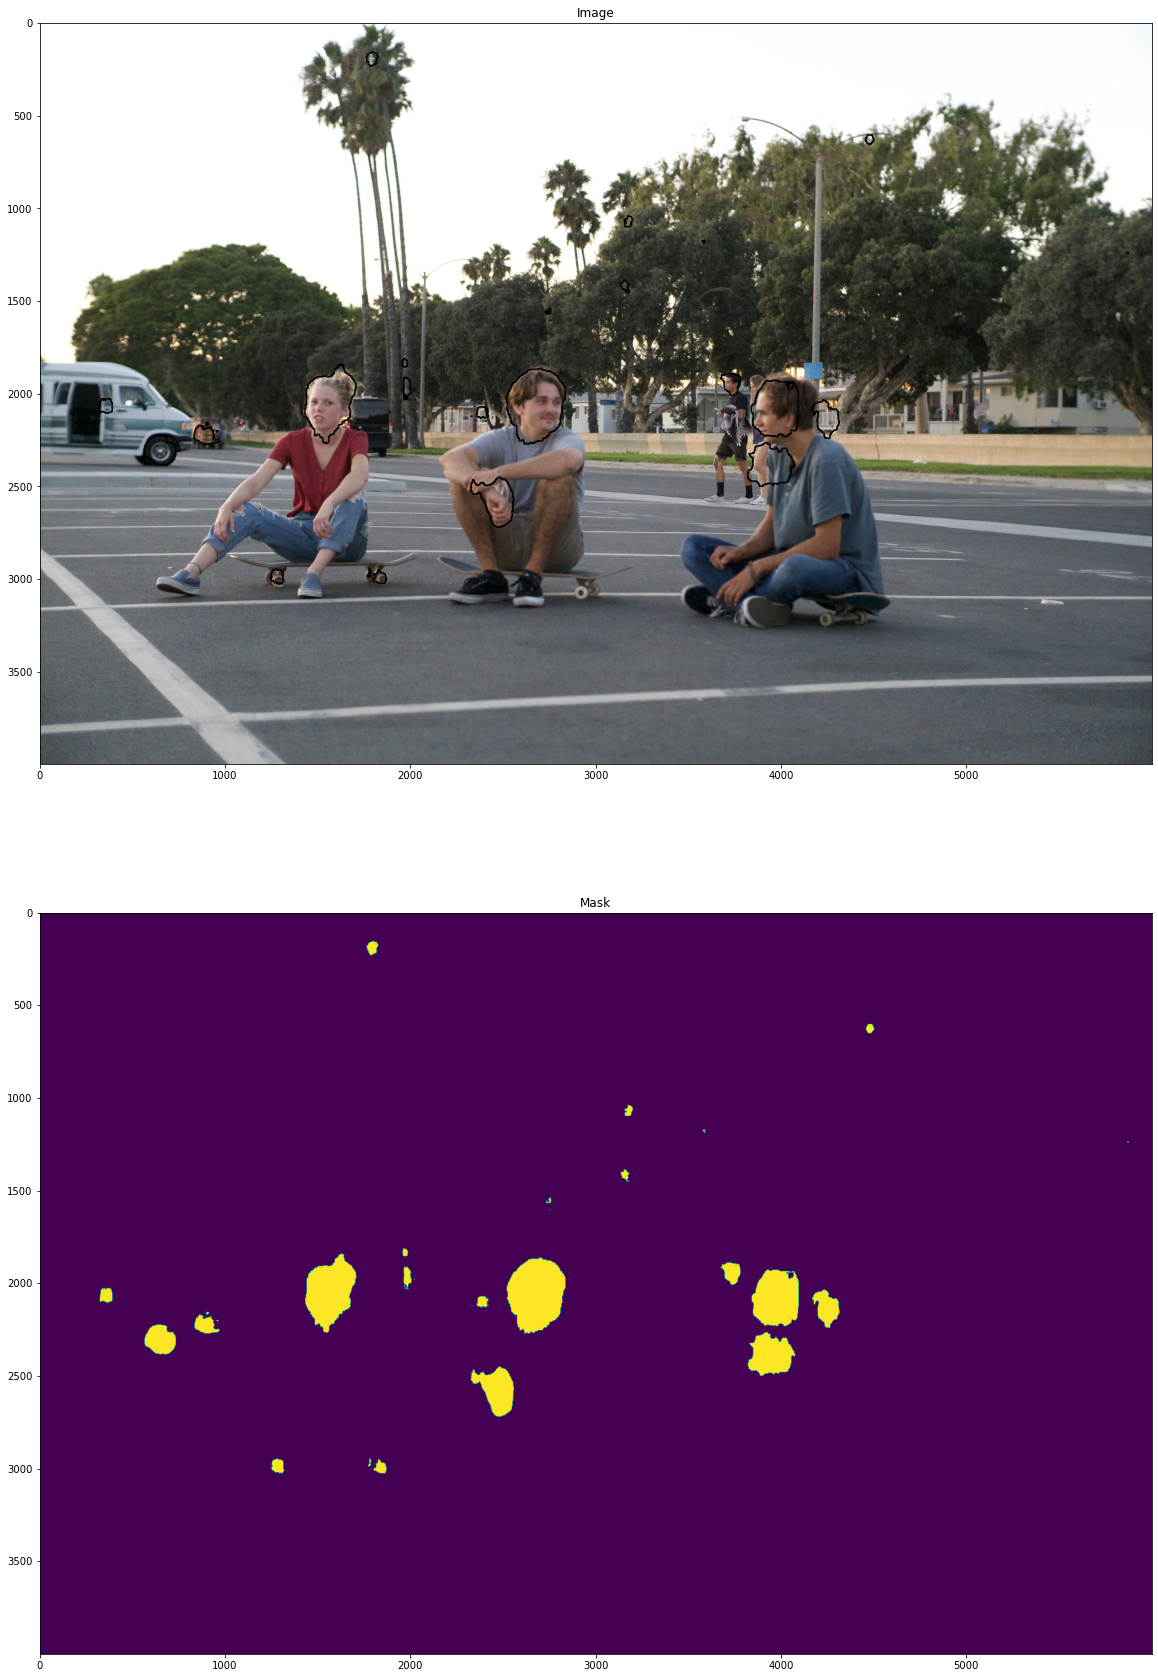

In [9]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (30, 30))
ax1.imshow(image.astype('uint8'))
ax1.contour(upsampled_mask.squeeze(), colors='k', levels=[0.5])
ax1.set_title('Image')

ax2.imshow(upsampled_mask.squeeze(), vmin=0, vmax=1)
ax2.set_title('Mask')